In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from models.crnn import CRNN
from models.convlstm import Conv1DLSTM
from models.convlstm_fcn_all import Conv1DLSTM_All

from utils.train_utils import train, EarlyStopping, load_checkpoint, count_parameters, epoch_time
from utils.test_utils import evaluate
from utils.visualization import get_predictions, plot_confusion_matrix


import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import random
import time

In [2]:
SEED = 37

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset Loader

In [3]:
ROOT =  "/home/yi/Desktop/momask-codes/signal_processing/fig/"
data_dir = os.path.join(ROOT, 'ci4r')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

pretrained_size = 224
pretrained_means = [0.0101, 0.0296, 0.5149]
pretrained_stds= [0.0807, 0.1463, 0.0947]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [4]:
print(test_data.classes)

['bend', 'crawl', 'kneel', 'limp', 'pick', 'scissor', 'sit', 'step', 'walk_away', 'walk_toes', 'walk_towards']


# Option 1: class mapping

In [5]:
# This is an example dataset class
class CustomDataset(Dataset):
    def __init__(self, original_dataset, class_mapping):
        self.original_dataset = original_dataset
        self.class_mapping = class_mapping
        self.n_class = len(set(class_mapping.values()))
        self.classes = [original_dataset.classes[class_id] for class_id in sorted(set(class_mapping.values()))]

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, label = self.original_dataset[idx]
        # Map the original label to the new label
        mapped_label = self.class_mapping[label]
        return data, mapped_label
                                  

# Example: Original dataset with labels
# Let's say you have an original dataset with labels 0 to 9
# and you want to merge them into 2 classes: 0-4 as class 0 and 5-9 as class 1
  # This should be your original dataset
class_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 3, 6: 5, 7: 6, 8: 7, 9: 3, 10: 8}

# Create the custom dataset with merged classes
train_data = CustomDataset(train_data, class_mapping)
test_data = CustomDataset(test_data, class_mapping)

# Option 2: class dropping

In [78]:
print(test_data.classes)

['bend', 'crawl', 'kneel', 'limp', 'pick', 'scissor', 'sit', 'step', 'walk_away']


In [79]:
class FilteredDataset(Dataset):
    def __init__(self, original_dataset, classes_to_drop):
        # Filter out data points belonging to the classes we want to drop
        self.filtered_data = [
            (data, label) for data, label in original_dataset
            if label not in classes_to_drop
        ]
        # Store the names of the remaining classes
        self.classes = {label: name for label, name in original_dataset.classes.items() if label not in classes_to_drop}

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        return self.filtered_data[idx]


    
classes_to_drop = {5, 9}
# Create the filtered dataset with class names
train_data = FilteredDataset(train_data, classes_to_drop)


AttributeError: 'list' object has no attribute 'items'

In [6]:
print(train_data.classes, test_data.classes)

['bend', 'crawl', 'kneel', 'limp', 'pick', 'scissor', 'sit', 'step', 'walk_away'] ['bend', 'crawl', 'kneel', 'limp', 'pick', 'scissor', 'sit', 'step', 'walk_away']


In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

# Linear FT

In [29]:
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
fc = nn.Linear(IN_FEATURES, 8)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

The model has 11,180,616 trainable parameters


In [30]:
model_path = 'resnet_model.pth'
model.load_state_dict(torch.load(model_path))
# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False


# Replace the last layer
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

# Make sure the last layer is unfrozen to fine-tune it
for param in model.fc.parameters():
    param.requires_grad = True

EPOCHS = 100

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

model = model.to(device)
criterion = criterion.to(device)

In [10]:
checkpoint_path = 'resnet_linear_ft_checkpoint.pth'
model_path = 'resnet_linear_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.928 | Train Acc:  25.67%
	Valid Loss: 1.595 | Valid Acc:  40.38%
	Test Loss: 1.733 | Test Acc:  25.00%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 1.493 | Train Acc:  47.48%
	Valid Loss: 1.342 | Valid Acc:  59.62%
	Test Loss: 1.407 | Test Acc:  50.00%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 1.276 | Train Acc:  53.43%
	Valid Loss: 1.237 | Valid Acc:  57.69%
	Test Loss: 1.344 | Test Acc:  52.60%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 1.185 | Train Acc:  55.97%
	Valid Loss: 1.141 | Valid Acc:  67.31%
	Test Loss: 1.144 | Test Acc:  61.81%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 1.081 | Train Acc:  62.04%
	Valid Loss: 1.104 | Valid Acc:  67.31%
	Test Loss: 1.165 | Test Acc:  56.25%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 1.066 | Train Acc:  56.53%
	Valid Loss: 1.058 | Valid Acc:  63.46%
	Test Loss: 1.122 | Test Acc:  59.38%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 1.001 | Train Acc:  64.47%
	Valid Loss: 1.027 | Valid Acc:  63.46%
	T

Epoch: 51 | Epoch Time: 0m 4s
	Train Loss: 0.614 | Train Acc:  79.06%
	Valid Loss: 0.718 | Valid Acc:  76.92%
	Test Loss: 0.794 | Test Acc:  75.87%
INFO: Early stopping counter 2 of 10
Epoch: 52 | Epoch Time: 0m 4s
	Train Loss: 0.603 | Train Acc:  77.47%
	Valid Loss: 0.724 | Valid Acc:  76.92%
	Test Loss: 0.816 | Test Acc:  74.31%
INFO: Early stopping counter 3 of 10
Epoch: 53 | Epoch Time: 0m 4s
	Train Loss: 0.608 | Train Acc:  77.80%
	Valid Loss: 0.722 | Valid Acc:  75.00%
	Test Loss: 0.861 | Test Acc:  69.27%
INFO: Early stopping counter 4 of 10
Epoch: 54 | Epoch Time: 0m 4s
	Train Loss: 0.638 | Train Acc:  77.37%
	Valid Loss: 0.709 | Valid Acc:  75.00%
	Test Loss: 0.773 | Test Acc:  73.78%
Epoch: 55 | Epoch Time: 0m 4s
	Train Loss: 0.605 | Train Acc:  77.69%
	Valid Loss: 0.729 | Valid Acc:  76.92%
	Test Loss: 0.822 | Test Acc:  67.19%
INFO: Early stopping counter 1 of 10
Epoch: 56 | Epoch Time: 0m 4s
	Train Loss: 0.624 | Train Acc:  78.56%
	Valid Loss: 0.704 | Valid Acc:  76.92%
	T

In [11]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.811 | Test Acc :  70.31% 


In [31]:
checkpoint_path = 'resnet_linear_ft_checkpoint.pth'
model_path = 'resnet_linear_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.158 | Train Acc:  22.92%
	Valid Loss: 1.687 | Valid Acc:  38.46%
	Test Loss: 1.966 | Test Acc:  24.48%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 1.604 | Train Acc:  40.84%
	Valid Loss: 1.411 | Valid Acc:  50.00%
	Test Loss: 1.488 | Test Acc:  48.44%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 1.366 | Train Acc:  52.54%
	Valid Loss: 1.274 | Valid Acc:  51.92%
	Test Loss: 1.370 | Test Acc:  43.92%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 1.223 | Train Acc:  55.27%
	Valid Loss: 1.221 | Valid Acc:  63.46%
	Test Loss: 1.244 | Test Acc:  53.12%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 1.156 | Train Acc:  59.18%
	Valid Loss: 1.140 | Valid Acc:  63.46%
	Test Loss: 1.230 | Test Acc:  55.73%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 1.105 | Train Acc:  56.16%
	Valid Loss: 1.092 | Valid Acc:  63.46%
	Test Loss: 1.170 | Test Acc:  58.33%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 1.046 | Train Acc:  64.00%
	Valid Loss: 1.086 | Valid Acc:  61.54%
	T

Epoch: 50 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc:  74.91%
	Valid Loss: 0.769 | Valid Acc:  75.00%
	Test Loss: 0.880 | Test Acc:  68.23%
INFO: Early stopping counter 5 of 10
Epoch: 51 | Epoch Time: 0m 4s
	Train Loss: 0.646 | Train Acc:  76.50%
	Valid Loss: 0.738 | Valid Acc:  76.92%
	Test Loss: 0.833 | Test Acc:  68.75%
INFO: Early stopping counter 6 of 10
Epoch: 52 | Epoch Time: 0m 4s
	Train Loss: 0.638 | Train Acc:  77.47%
	Valid Loss: 0.721 | Valid Acc:  78.85%
	Test Loss: 0.852 | Test Acc:  67.71%
Epoch: 53 | Epoch Time: 0m 4s
	Train Loss: 0.749 | Train Acc:  73.65%
	Valid Loss: 0.776 | Valid Acc:  76.92%
	Test Loss: 0.896 | Test Acc:  69.27%
INFO: Early stopping counter 1 of 10
Epoch: 54 | Epoch Time: 0m 4s
	Train Loss: 0.618 | Train Acc:  80.14%
	Valid Loss: 0.722 | Valid Acc:  80.77%
	Test Loss: 0.823 | Test Acc:  68.75%
INFO: Early stopping counter 2 of 10
Epoch: 55 | Epoch Time: 0m 4s
	Train Loss: 0.611 | Train Acc:  78.58%
	Valid Loss: 0.753 | Valid Acc:  75.00%
	T

In [32]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.842 | Test Acc :  70.31% 


In [33]:
checkpoint_path = 'resnet_linear_ft_checkpoint.pth'
model_path = 'resnet_linear_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.547 | Train Acc:  81.23%
	Valid Loss: 0.636 | Valid Acc:  78.85%
	Test Loss: 0.810 | Test Acc:  69.79%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.548 | Train Acc:  81.81%
	Valid Loss: 0.708 | Valid Acc:  76.92%
	Test Loss: 0.798 | Test Acc:  69.79%
INFO: Early stopping counter 1 of 10
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.571 | Train Acc:  80.53%
	Valid Loss: 0.684 | Valid Acc:  78.85%
	Test Loss: 0.762 | Test Acc:  69.79%
INFO: Early stopping counter 2 of 10
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.541 | Train Acc:  83.68%
	Valid Loss: 0.688 | Valid Acc:  78.85%
	Test Loss: 0.796 | Test Acc:  69.27%
INFO: Early stopping counter 3 of 10
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.592 | Train Acc:  77.34%
	Valid Loss: 0.652 | Valid Acc:  76.92%
	Test Loss: 0.831 | Test Acc:  68.75%
INFO: Early stopping counter 4 of 10
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.560 | Train Acc:  79.75%
	Valid Loss: 0.734 | Valid Acc:  75.00%
	T

In [34]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.810 | Test Acc :  69.79% 


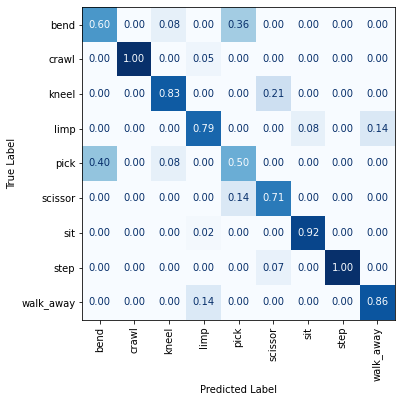

In [12]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes, 'resnet.png')

# Layer FT

In [13]:
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, 8)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

The model has 11,180,616 trainable parameters


In [14]:
model_path = 'resnet_model.pth'
model.load_state_dict(torch.load(model_path))

# Replace the last layer
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

# Make sure the last layer is unfrozen to fine-tune it
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

EPOCHS = 100

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

model = model.to(device)
criterion = criterion.to(device)

In [15]:
checkpoint_path = 'resnet_layer_ft_checkpoint.pth'
model_path = 'resnet_layer_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.515 | Train Acc:  47.11%
	Valid Loss: 1.197 | Valid Acc:  50.00%
	Test Loss: 0.893 | Test Acc:  70.83%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.792 | Train Acc:  70.70%
	Valid Loss: 1.201 | Valid Acc:  53.85%
	Test Loss: 0.902 | Test Acc:  61.46%
INFO: Early stopping counter 1 of 10
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.538 | Train Acc:  81.42%
	Valid Loss: 0.562 | Valid Acc:  80.77%
	Test Loss: 0.575 | Test Acc:  77.43%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.358 | Train Acc:  88.43%
	Valid Loss: 0.500 | Valid Acc:  84.62%
	Test Loss: 0.592 | Test Acc:  80.03%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.282 | Train Acc:  90.89%
	Valid Loss: 0.468 | Valid Acc:  86.54%
	Test Loss: 0.489 | Test Acc:  82.64%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.191 | Train Acc:  95.40%
	Valid Loss: 0.441 | Valid Acc:  82.69%
	Test Loss: 0.637 | Test Acc:  75.52%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.156 | Train Acc:  96.88%
	Vali

INFO: Early stopping counter 5 of 10
Epoch: 48 | Epoch Time: 0m 4s
	Train Loss: 0.001 | Train Acc: 100.00%
	Valid Loss: 0.310 | Valid Acc:  92.31%
	Test Loss: 1.313 | Test Acc:  76.56%
INFO: Early stopping counter 6 of 10
Epoch: 49 | Epoch Time: 0m 4s
	Train Loss: 0.001 | Train Acc: 100.00%
	Valid Loss: 0.313 | Valid Acc:  92.31%
	Test Loss: 1.277 | Test Acc:  76.56%
INFO: Early stopping counter 7 of 10
Epoch: 50 | Epoch Time: 0m 4s
	Train Loss: 0.001 | Train Acc: 100.00%
	Valid Loss: 0.318 | Valid Acc:  92.31%
	Test Loss: 1.219 | Test Acc:  76.56%
INFO: Early stopping counter 8 of 10
Epoch: 51 | Epoch Time: 0m 4s
	Train Loss: 0.001 | Train Acc: 100.00%
	Valid Loss: 0.326 | Valid Acc:  92.31%
	Test Loss: 1.220 | Test Acc:  76.56%
INFO: Early stopping counter 9 of 10
Epoch: 52 | Epoch Time: 0m 4s
	Train Loss: 0.007 | Train Acc:  99.80%
	Valid Loss: 0.626 | Valid Acc:  84.62%
	Test Loss: 0.999 | Test Acc:  73.44%
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Early stopping a

In [16]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 1.219 | Test Acc :  77.08% 


# SCL FT

In [17]:
class CustomResNetBlock(nn.Module):
    def __init__(self, original_layer4_block2):
        super(CustomResNetBlock, self).__init__()
        self.layer4_block2 = original_layer4_block2

    def forward(self, x):
        # Save the original input for the skip connection
        identity = x
        
        # Pass the input through the original layer 4
        out = self.layer4_block2(x)
        
        #print(out.shape, identity.shape)
        
        # Add the skip connection (identity)
        out += identity
        
        return out

# Load a pre-trained ResNet18 model
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, 8)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model_path = 'resnet_model.pth'
model.load_state_dict(torch.load(model_path))
print(model.layer4[1])
model.layer4[1].relu = nn.ReLU(inplace=False)
# Replace layer 4 with the custom module that includes a skip connection
model.layer4[1] = CustomResNetBlock(model.layer4[1])


# Replace the last layer
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

# Example: Freeze all layers except the custom layer4 and the fc layer
for name, param in model.named_parameters():
    if not any([name.startswith('layer4.1'), name.startswith('fc')]):
        param.requires_grad = False

The model has 11,180,616 trainable parameters
BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [18]:
EPOCHS = 100

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

model = model.to(device)
criterion = criterion.to(device)

In [19]:
checkpoint_path = 'resnet_scl_ft_checkpoint.pth'
model_path = 'resnet_scl_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.766 | Train Acc:  37.67%
	Valid Loss: 1.428 | Valid Acc:  46.15%
	Test Loss: 1.306 | Test Acc:  53.65%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 1.065 | Train Acc:  64.78%
	Valid Loss: 0.949 | Valid Acc:  69.23%
	Test Loss: 0.824 | Test Acc:  74.83%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.733 | Train Acc:  74.65%
	Valid Loss: 0.824 | Valid Acc:  73.08%
	Test Loss: 0.850 | Test Acc:  78.47%
INFO: Early stopping counter 1 of 10
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.605 | Train Acc:  80.21%
	Valid Loss: 0.646 | Valid Acc:  76.92%
	Test Loss: 0.677 | Test Acc:  78.99%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.492 | Train Acc:  83.44%
	Valid Loss: 0.589 | Valid Acc:  80.77%
	Test Loss: 0.610 | Test Acc:  76.91%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.377 | Train Acc:  88.65%
	Valid Loss: 0.523 | Valid Acc:  82.69%
	Test Loss: 0.687 | Test Acc:  76.56%
INFO: Early stopping counter 1 of 10
Epoch: 07 | Epoch Time: 0m 4s
	Train L

In [20]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.634 | Test Acc :  77.60% 


# All Model FT

In [21]:
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, 8)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

The model has 11,180,616 trainable parameters


In [22]:
model_path = 'resnet_model.pth'
model.load_state_dict(torch.load(model_path))

# Replace the last layer
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

# Make sure the last layer is unfrozen to fine-tune it
for param in model.parameters():
    param.requires_grad = True

EPOCHS = 100

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

model = model.to(device)
criterion = criterion.to(device)

In [23]:
checkpoint_path = 'resnet_all_ft_checkpoint.pth'
model_path = 'resnet_all_ft_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.377 | Train Acc:  53.28%
	Valid Loss: 1.092 | Valid Acc:  57.69%
	Test Loss: 1.560 | Test Acc:  49.83%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.571 | Train Acc:  82.57%
	Valid Loss: 0.809 | Valid Acc:  65.38%
	Test Loss: 1.407 | Test Acc:  48.96%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.341 | Train Acc:  86.00%
	Valid Loss: 0.659 | Valid Acc:  80.77%
	Test Loss: 0.391 | Test Acc:  84.55%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.242 | Train Acc:  94.53%
	Valid Loss: 0.631 | Valid Acc:  75.00%
	Test Loss: 0.640 | Test Acc:  78.47%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.165 | Train Acc:  95.79%
	Valid Loss: 0.520 | Valid Acc:  80.77%
	Test Loss: 0.282 | Test Acc:  89.76%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.093 | Train Acc:  97.35%
	Valid Loss: 0.438 | Valid Acc:  80.77%
	Test Loss: 0.303 | Test Acc:  84.20%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.069 | Train Acc:  98.44%
	Valid Loss: 0.353 | Valid Acc:  88.46%
	T

In [24]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.379 | Test Acc :  84.72% 


# Scratch

In [25]:
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 100

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

model = model.to(device)
criterion = criterion.to(device)

The model has 11,181,129 trainable parameters


In [26]:
checkpoint_path = 'resnet_scratch_checkpoint.pth'
model_path = 'resnet_scratch_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 1.481 | Train Acc:  42.95%
	Valid Loss: 25.490 | Valid Acc:  40.38%
	Test Loss: 42.992 | Test Acc:  20.83%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.994 | Train Acc:  60.48%
	Valid Loss: 1.172 | Valid Acc:  59.62%
	Test Loss: 1.820 | Test Acc:  36.98%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.667 | Train Acc:  81.60%
	Valid Loss: 1.180 | Valid Acc:  51.92%
	Test Loss: 1.707 | Test Acc:  38.02%
INFO: Early stopping counter 1 of 10
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.574 | Train Acc:  78.30%
	Valid Loss: 0.461 | Valid Acc:  73.08%
	Test Loss: 0.755 | Test Acc:  69.10%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.515 | Train Acc:  80.75%
	Valid Loss: 0.474 | Valid Acc:  84.62%
	Test Loss: 0.376 | Test Acc:  82.99%
INFO: Early stopping counter 1 of 10
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.359 | Train Acc:  87.98%
	Valid Loss: 0.525 | Valid Acc:  76.92%
	Test Loss: 0.387 | Test Acc:  85.07%
INFO: Early stopping counter 2 of 10

In [27]:
model_path = 'resnet_scratch_model.pth'

model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc : {test_acc*100:6.2f}% ')

Test Loss: 0.482 | Test Acc :  80.56% 


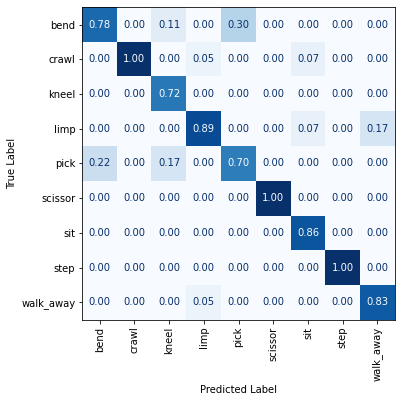

In [28]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes, 'resnet.png')

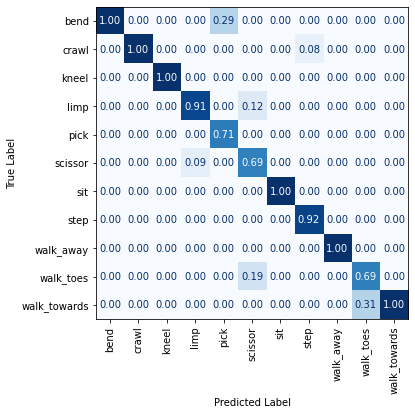